In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Apertura dei dati da Google Drive
#Caricamento dei file testuali per navigare nelle cartelle e prendere le immagini
file=open("./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/train.txt", "r")
content = file.read()
train_set = content.strip().split(",")
print(train_set)
file.close()

file=open("./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/test.txt", "r")
content = file.read()
test_set = content.strip().split(",")
print(test_set)
file.close()


file=open("./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/all.txt", "r")
content = file.read()
all_locs = content.strip().split(",")
print(all_locs)
file.close()

channels = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes', 'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong', 'beirut', 'mumbai']
['brasilia', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia', 'dubai', 'lasvegas', 'milano', 'chongqing']
['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes', 'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong', 'beirut', 'mumbai', 'brasilia', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia', 'dubai', 'lasvegas', 'milano', 'chongqing']


In [ ]:
!pip install elasticdeform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 10.4 MB/s eta 0:00:00


In [ ]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from math import floor, ceil, sqrt, exp

import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from torch.autograd import Variable

import time
from IPython import display


print('IMPORTS OK')

class RandomBlurorSharpen():
    def __init__(self, kernel_size=3, probability=0.25):
        self.kernel_size = kernel_size
        self.probability = probability

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        # Applica randomicamente il filtro
        rn=random.random()
        if  rn < self.probability:
            # Filtro di sharpening
            #if random.random()<0.5:
              blurred = TF.gaussian_blur(I1, kernel_size=self.kernel_size)
              I1 = (2 * I1 - blurred)
            #else:
              blurred = TF.gaussian_blur(I2, kernel_size=self.kernel_size)
              I2 = (2 * I2 - blurred)
        elif rn < 2*self.probability:
            # Filtro gaussiano
            #if random.random()<0.5:
              I1 = TF.gaussian_blur(I1, kernel_size=self.kernel_size)
            #else:
              I2 = TF.gaussian_blur(I2, kernel_size=self.kernel_size)

        return {'I1': I1, 'I2': I2, 'label': label}


class RandomNoise():
  def __init__(self, prob=0.1):
    # Probabilità di avere pixel rumorosi
    self.prob=prob

  def __call__(self,sample):
    I1, I2, label = sample['I1'], sample['I2'], sample['label']
    # Genera rumore salt and pepper
    noise = np.random.choice([0, 1], size=I1.shape[1:], p=[1 - self.prob, self.prob])
    
    # Applica il rumore salt and pepper all'immagine
    I1 = torch.from_numpy((I1.numpy() * (1 - noise) + noise))
    I2 = torch.from_numpy((I2.numpy() * (1 - noise) + noise))
    return {'I1': I1, 'I2': I2, 'label': label}

class RandomFlip():
    """Flip randomly the images in a sample."""
    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot():
    """Rotate randomly the images in a sample."""
    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}

class RandomJitter():
    def __init__(self, saturation_range=(0.8, 1.2), contrast_range=(0.8, 1.2),
                 hue_range=(-0.1, 0.1), brightness_range=(0.8,1.2)):
        self.saturation_range = saturation_range
        self.contrast_range = contrast_range
        self.hue_range = hue_range
        self.brightness_range = brightness_range

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        if random.random()<0.95:
          return {'I1': I1, 'I2': I2, 'label': label}
        
        rn=random.randint(0,3)
        
        if rn==0:
          # Applica jitter casuale alla saturazione
          saturation_factor = random.uniform(self.saturation_range[0], self.saturation_range[1])
          I1[1:4] = TF.adjust_saturation(I1[1:4], saturation_factor)
          I2[1:4] = TF.adjust_saturation(I2[1:4], saturation_factor)
        elif rn==1:
          # Applica jitter casuale al contrasto
          contrast_factor = random.uniform(self.contrast_range[0], self.contrast_range[1])
          I1[1:4] = TF.adjust_contrast(I1[1:4], contrast_factor)
          I2[1:4] = TF.adjust_contrast(I2[1:4], contrast_factor)
        elif rn==2:
          # Applica jitter casuale alla tonalità
          hue_factor = random.uniform(self.hue_range[0], self.hue_range[1])
          I1[1:4] = TF.adjust_hue(I1[1:4], hue_factor)
          I2[1:4] = TF.adjust_hue(I2[1:4], hue_factor)
        elif rn==3:
          # Applica jitter casuale alla luminosità
          brightness_factor = random.uniform(self.brightness_range[0], self.brightness_range[1])
          I1[1:4] = TF.adjust_brightness(I1[1:4], brightness_factor)
          I2[1:4] = TF.adjust_brightness(I2[1:4], brightness_factor)

        return {'I1': I1, 'I2': I2, 'label': label}

import elasticdeform

class RandomElasticDistortion():
    def __init__(self, sigma_min=20, sigma_max=50):
      #fattore di deformazione
      self.sigma_min=sigma_min
      self.sigma_max=sigma_max

    def __call__(self, sample):
      I1, I2, label = sample['I1'], sample['I2'], sample['label']

      #randomicamente restituisce il sample così com'è
      if random.random()<0.5:
        return sample

      else:
        sigma=random.randint(self.sigma_min,self.sigma_max)
        shape = I1.shape[1:]
        #creazione della griglia di deformazione
        displacement = np.random.randn(2, 3, 3) * sigma
        I1, I2, label = I1.numpy(), I2.numpy(), label.numpy()
        #applica la deformazione alle immagini
        label =  elasticdeform.deform_grid(label, displacement)
        I1 = elasticdeform.deform_grid(I1, displacement, axis=(1,2))
        I2 = elasticdeform.deform_grid(I2, displacement, axis=(1,2))
  
      return {'I1': torch.from_numpy(I1), 'I2': torch.from_numpy(I2), 'label': torch.from_numpy(label)}

transform=transforms.Compose([
    #RandomJitter(),
    RandomFlip(),
    RandomRot(),
    RandomNoise(),
    RandomBlurorSharpen(),
    RandomElasticDistortion()
])


#Inizilizzazione del dataset
class OSCD_dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, normalize=True, transform=None, patch_side = 96, stride = None):
        self.train=train
        self.transform=transform
        self.normalize=normalize
        self.patch_side=patch_side
        self.stride=1
        if stride:
          self.stride=stride
              
        #Carica i dati dai file
        self.load_data()

    def __len__(self):
        # Restituisci la lunghezza del dataset
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        loc = current_patch_coords[0]
        limits = current_patch_coords[1]

        I1 = self.imgs_1[loc][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[loc][:, limits[0]:limits[1], limits[2]:limits[3]]
        label = self.change_maps[loc][limits[0]:limits[1], limits[2]:limits[3]]
      

        I1 = torch.from_numpy(I1)
        I2 = torch.from_numpy(I2)
        label = torch.from_numpy(label).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def get_img(self, loc):
       return self.imgs_1[loc], self.imgs_2[loc], self.change_maps[loc]


    def load_data(self):
      #selezione del sottoinsieme richiesto
      
        if self.train:
          self.req_set=train_set
        else:
          self.req_set=test_set
        all_data = []  # Lista per memorizzare tutti i dati da tutti i file
        all_imgs = []

        #per le patches: dal paper
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        #per i pesi change/no-change  
        n_pix = 0
        true_pix = 0

        for loc in self.req_set:
            print('loading:', loc)
            img1_list = []
            img2_list = []

            for channel in channels:
                #prendo le immagini di ogni canale e le metto in una lista
                ch = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/' + loc + '/imgs_1_rect/' + channel + '.tif')
                img1_list.append(np.array(ch))
                ch = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/' + loc + '/imgs_2_rect/' + channel + '.tif')
                img2_list.append(np.array(ch))    
            if self.train:
                #carico l'immagine della ground truth
                gt = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_train_labels/' + loc + '/cm/' + loc + '-cm.tif')
            else:
                gt = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_test_labels/' + loc + '/cm/' + loc + '-cm.tif')
            #la ground truth ha pixel 1 (no change) e 2 (change)
            gt=np.array(gt)-1

            #reshape dell'immagine alle dimensioni HxWxC
            img1=np.array(img1_list).transpose((1,2,0))
            img2=np.array(img2_list).transpose((1,2,0))
            if self.normalize:
                           
              img1=(img1-img1.mean(axis=(0,1)))/img1.std(axis=(0,1))
              img2=(img2-img2.mean(axis=(0,1)))/img2.std(axis=(0,1))


            #immagine diventa CxHxW come il tensore che la conterrà
            img1=img1.transpose(2,0,1)
            img2=img2.transpose(2,0,1)
    
            # load and store each image
            
            self.imgs_1[loc] = img1
            self.imgs_2[loc] = img2
            self.change_maps[loc] = gt
            
            s = gt.shape
            n_pix += np.prod(s)
            true_pix += gt.sum()
            
            # calculate the number of patches
            s = img1.shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2


            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (loc, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side])
                    self.patch_coords.append(current_patch_coords)
            
            #more random patches
            more_patches=0
            '''
            if self.train:
              more_patches=n_patches_i
              for i in range(more_patches):
                x=random.randint(0,s[1]-1-self.patch_side)
                y=random.randint(0,s[2]-1-self.patch_side)
                current_patch_coords = (loc,[x,x+self.patch_side,y,y+self.patch_side])
                self.patch_coords.append(current_patch_coords)
            '''
            self.n_patches_per_image[loc] = n_patches_i+more_patches
            self.n_patches += (n_patches_i+more_patches)
            

        #RIDEFINIZIONE PESI
        self.weights = np.array([ true_pix , (n_pix - true_pix) ])
        return 


patch_side=96

train_set_imgs=OSCD_dataset(train=True,transform=transform,stride=(int)(patch_side/2) - 1)
test_set_imgs=OSCD_dataset(train=False, stride=(int)(patch_side/2) - 1)

train_loader = DataLoader(train_set_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set_imgs, batch_size=32, shuffle=True)

#così ho true_pix_total, n_pix_total-true_pix_total
weights=(train_set_imgs.weights+test_set_imgs.weights)
#pesi 1, (n_pix-true_pix)/true_pix
weights/=weights[0]
#normalizzazione dei pesi affinché sommino a 2
#weights=weights/weights.sum() * 2
#normalizzazione dei pesi affinché sommino a 1
weights=weights/weights.sum()

print(weights)

IMPORTS OK
loading: aguasclaras
loading: bercy
loading: bordeaux
loading: nantes
loading: paris
loading: rennes
loading: saclay_e
loading: abudhabi
loading: cupertino
loading: pisa
loading: beihai
loading: hongkong
loading: beirut
loading: mumbai
loading: brasilia
loading: montpellier
loading: norcia
loading: rio
loading: saclay_w
loading: valencia
loading: dubai
loading: lasvegas
loading: milano
loading: chongqing
[0.03212616 0.96787384]


torch.Size([3, 471, 525])


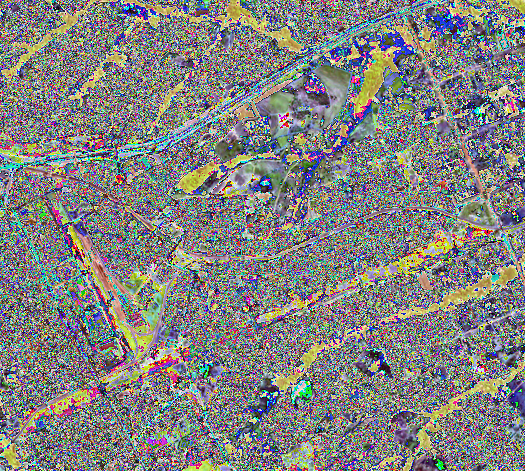

torch.Size([1, 471, 525])


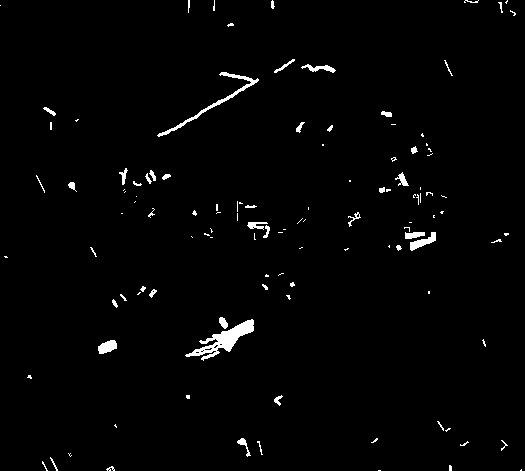

torch.Size([3, 471, 525])


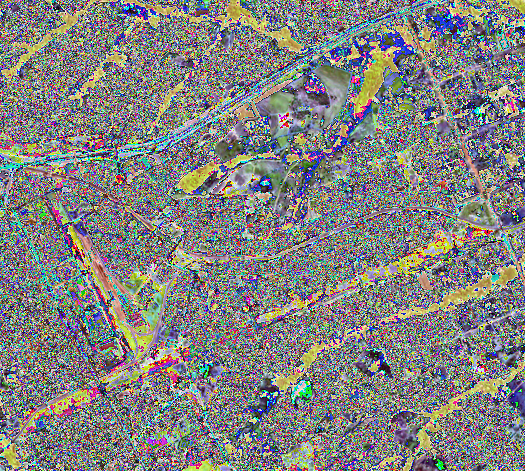

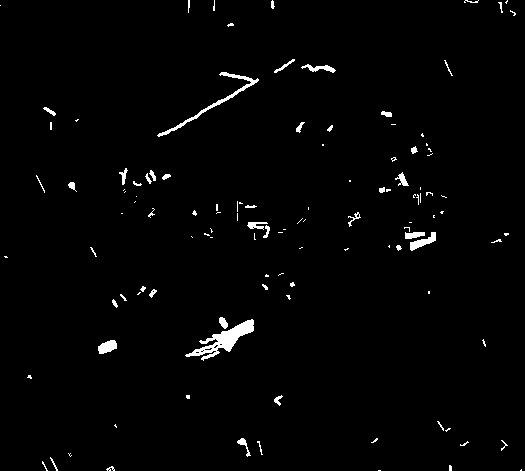

In [ ]:

image=train_set_imgs.get_img('aguasclaras')
#print(image)

rgb_image = torch.from_numpy(image[0][1:4, :, :])  # Seleziona solo i canali 1, 2 e 3 (RGB)
print(rgb_image.shape)
rgb_image_pil = TF.to_pil_image(rgb_image)
# Visualizza l'immagine RGB
rgb_image_pil.show()

print(torch.from_numpy(image[2]).int().unsqueeze(0).shape)
rgb_image_pil = TF.to_pil_image(torch.from_numpy(image[2]).unsqueeze(0).int()*255)
# Visualizza l'immagine label
rgb_image_pil.show()

image=RandomElasticDistortion()({'I1':torch.from_numpy(image[0]),'I2':torch.from_numpy(image[1]),'label':torch.from_numpy(image[2])})
rgb_image = image['I1'][1:4, :, :]  # Seleziona solo i canali 1, 2 e 3 (RGB)
print(rgb_image.shape)
rgb_image_pil = TF.to_pil_image(rgb_image)
# Visualizza l'immagine RGB
rgb_image_pil.show()

rgb_image_pil = TF.to_pil_image((image['label']).unsqueeze(0).int()*255)
# Visualizza l'immagine label
rgb_image_pil.show()

In [ ]:
USE_SIGMOID=False
USE_SIAMESE=False

N_EPOCHS = 30

LOAD_TRAINED = False

print('DEFINITIONS OK')

DEFINITIONS OK


In [ ]:
''
# Rodrigo Caye Daudt
# https://rcdaudt.github.io/
# Daudt, R. C., Le Saux, B., & Boulch, A. "Fully convolutional siamese networks for change detection". In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.do42 = nn.Dropout2d(p=0.5)

        self.conv51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(1024)
        self.conv52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(1024)
        self.do52 =  nn.Dropout2d(p=0.5)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv42d = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512)
        self.conv41d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv32d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256)
        self.conv31d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128)
        self.conv21d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv13d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn13d = nn.BatchNorm2d(64)
        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)


    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        
        """Forward method."""
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x3p = F.max_pool2d(x32, kernel_size=2, stride=2)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x4p = F.max_pool2d(x42, kernel_size=2, stride=2)

        #Stage 5: Middle stage

        x5 = F.relu(self.bn51(self.conv51(x4p)))
        x5d = self.do52(F.relu(self.bn52(self.conv52(x5))))

        # Stage 4d
        x4d = self.upconv4(x5d)
        pad4 = ReplicationPad2d((0, x42.size(3) - x4d.size(3), 0, x42.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x42), 1)
        x42d = F.relu(self.bn42d(self.conv42d(x4d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x32.size(3) - x3d.size(3), 0, x32.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x32), 1)
        x32d = F.relu(self.bn32d(self.conv32d(x3d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x13d = F.relu(self.bn13d(self.conv13d(x1d)))
        x12d = F.relu(self.bn12d(self.conv12d(x13d)))
        x11d = self.conv11d(x12d)

        return x11d
        
if not USE_SIAMESE:
  if USE_SIGMOID: net, net_name = Unet(2*13, 1), 'FC-EF'
  else: net, net_name = Unet(2*13, 2), 'FC-EF'


In [ ]:
# Rodrigo Caye Daudt
# https://rcdaudt.github.io/
# Daudt, R. C., Le Saux, B., & Boulch, A. "Fully convolutional siamese networks for change detection". In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiamUnet_diff(nn.Module):
    """SiamUnet_diff segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_diff, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.do42 = nn.Dropout2d(p=0.5)

        self.conv51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(1024)
        self.conv52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(1024)
        self.do52 =  nn.Dropout2d(p=0.5)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv42d = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512)
        self.conv41d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv32d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256)
        self.conv31d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128)
        self.conv21d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv13d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn13d = nn.BatchNorm2d(64)
        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)


    def forward(self, x1, x2):

        """Forward method."""
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x1)))
        x12_1 = F.relu(self.bn12(self.conv12(x11)))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22_1 = F.relu(self.bn22(self.conv22(x21)))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32_1 = F.relu(self.bn32(self.conv32(x31)))
        x3p = F.max_pool2d(x32_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42_1 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x4p = F.max_pool2d(x42_1, kernel_size=2, stride=2)

        
        #Stage 5
        x5 = F.relu(self.bn51(self.conv51(x4p)))
        x5d_1 = self.do52(F.relu(self.bn52(self.conv52(x5))))
        

        ####################################################
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x2)))
        x12_2 = F.relu(self.bn12(self.conv12(x11)))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)


        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22_2 = F.relu(self.bn22(self.conv22(x21)))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32_2 = F.relu(self.bn32(self.conv32(x31)))
        x3p = F.max_pool2d(x32_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42_2 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x4p = F.max_pool2d(x42_2, kernel_size=2, stride=2)

        
        #Stage 5
        x5 = F.relu(self.bn51(self.conv51(x4p)))
        x5d_2 = self.do52(F.relu(self.bn52(self.conv52(x5))))
        

        # Stage 4d
        x4d = self.upconv4(x5d_2)
        pad4 = ReplicationPad2d((0, x42_1.size(3) - x4d.size(3), 0, x42_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x42_1 - x42_2)), 1)
        x42d = F.relu(self.bn42d(self.conv42d(x4d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x32_1.size(3) - x3d.size(3), 0, x32_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x32_1 - x32_2)), 1)
        x32d = F.relu(self.bn32d(self.conv32d(x3d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x13d = F.relu(self.bn13d(self.conv13d(x1d)))
        x12d = F.relu(self.bn12d(self.conv12d(x13d)))
        x11d = self.conv11d(x12d)

        return x11d
if USE_SIAMESE:
  if USE_SIGMOID: net, net_name = SiamUnet_diff(13, 1), 'FC-SIAM-DIFF'
  else: net, net_name = SiamUnet_diff(13, 2), 'FC-SIAM-DIFF'


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))



Number of trainable parameters: 34539458


In [ ]:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1+cu118  Device: cuda


In [ ]:
weights = torch.FloatTensor(weights).to(device)
print(weights)
#prima loss utilizzata: CrossEntropyLoss
#criterion = nn.CrossEntrpyLoss(weight=weights).to(device) # to be used with logsoftmax output

#definizione della focal loss
class FocalLoss(nn.Module):
  def __init__(self,gamma=2,alpha=weights,reduction='mean'):
    super(FocalLoss, self).__init__()
    self.gamma=gamma
    self.alpha=alpha
    self.reduction=reduction
  def forward(self,output,label):

    #Output NxCxHxW -> NxCxH*W
    output=output.view(output.shape[0],output.shape[1],-1)
    #Label NxHxW -> N*H*W
    label=label.view(-1)

    #Output NxCxH*W -> NxH*WxC -> N*H*WxC
    output=output.transpose(1,2)
    output=output.contiguous().view(-1,output.shape[2])

    #calcolo la log_softmax per i tutti i pixel
    output=F.log_softmax(output, dim=1)

    #prendo i valori della log_softmax corrispondenti alla label corretta
    #for i in len(output): output[i]=output[i][label[i]]
    output = output.gather(1,label.unsqueeze(1))

    #rimuovo l'ormai inutile dimensione delle classi 
    #(abbiamo preso le probabilità che ci servivano)
    output = output.view(-1)
    #o meglio: ne abbiamo preso il logaritmo, quindi ce le ricalcoliamo
    pt=torch.exp(output)

    #prendiamo il peso nel tensore alpha corrispondente al valore della label
    #per ogni pixel (pesi change/no_change)
    #at[i]=alpha[label[i]]
    at=self.alpha.gather(0,label)

    #calcolo il valore della loss: prodotto tra la potenza gamma della 
    #probabilità, per il peso corrispondente alla label, per il logaritmo
    #della probabilità (parte della cross entropy)
    focal_loss=-(1-pt)**self.gamma*at*output
    if self.reduction == 'mean':
        focal_loss = torch.mean(focal_loss)
    elif self.reduction == 'sum':
        focal_loss = torch.sum(focal_loss)
    return focal_loss

criterion = FocalLoss().to(device)
if USE_SIGMOID:
  criterion= nn.BCEWithLogitsLoss(pos_weight=weights[1]/weights[0])  

net.to(device)

tensor([0.0321, 0.9679], device='cuda:0')


Unet(
  (conv11): Conv2d(26, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

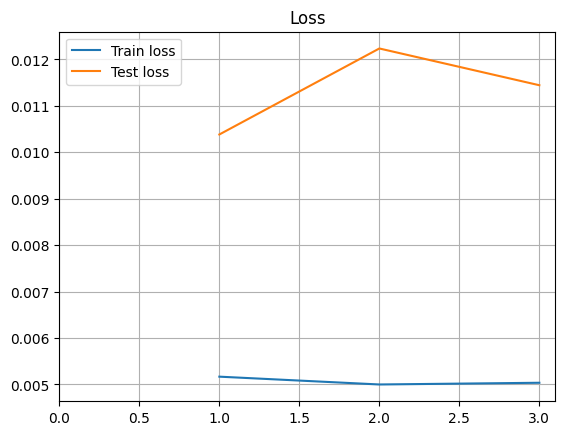

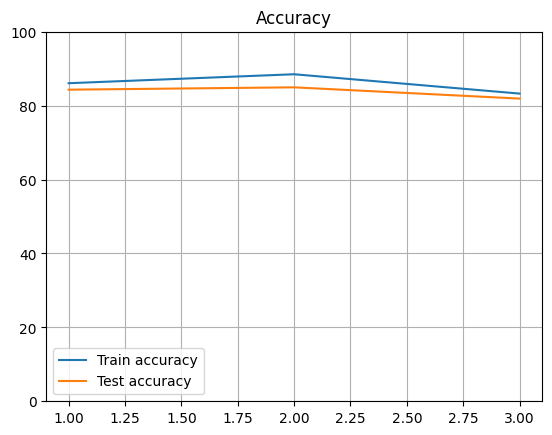

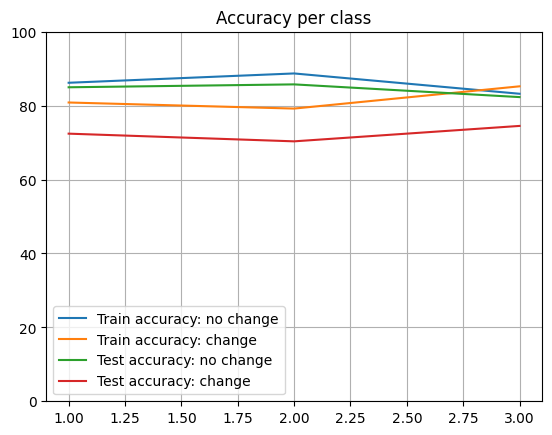

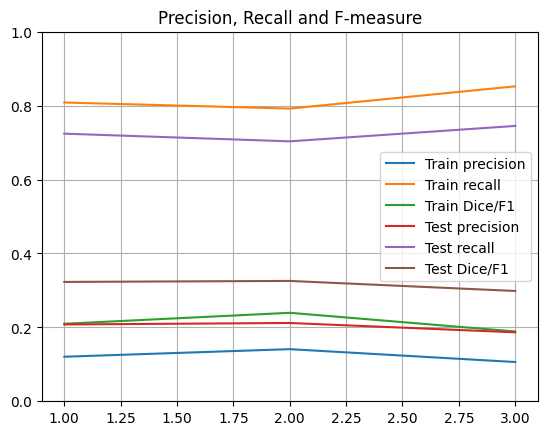

Epoch: 4 of 30
aguasclaras


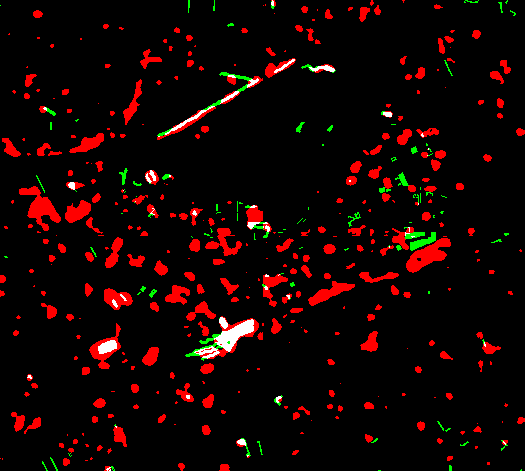

bercy


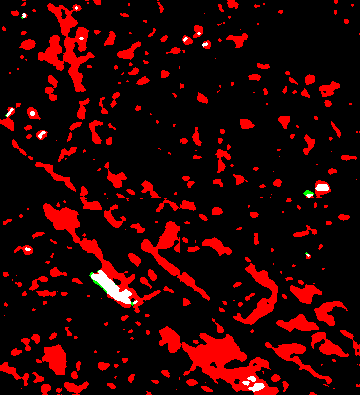

bordeaux


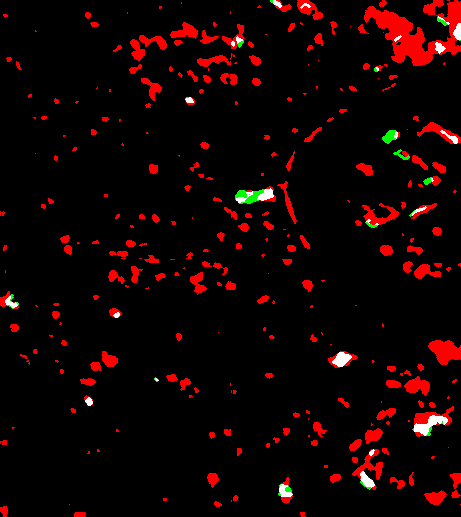

nantes


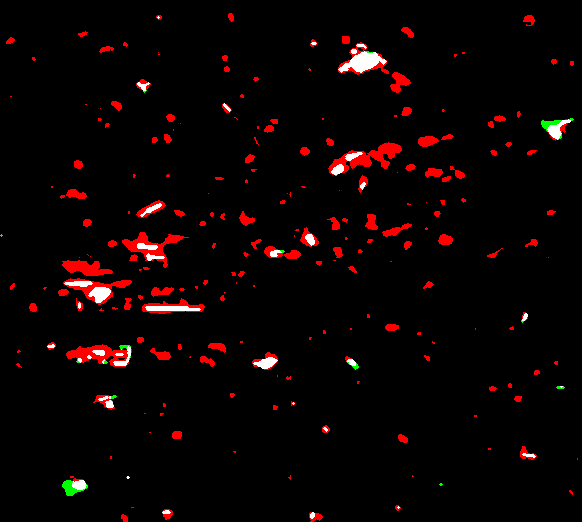

paris


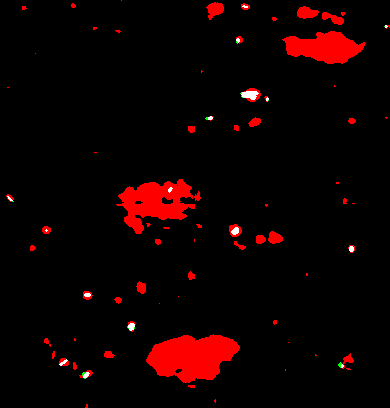

rennes


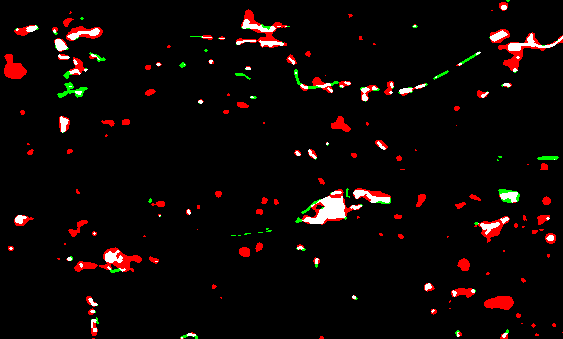

saclay_e


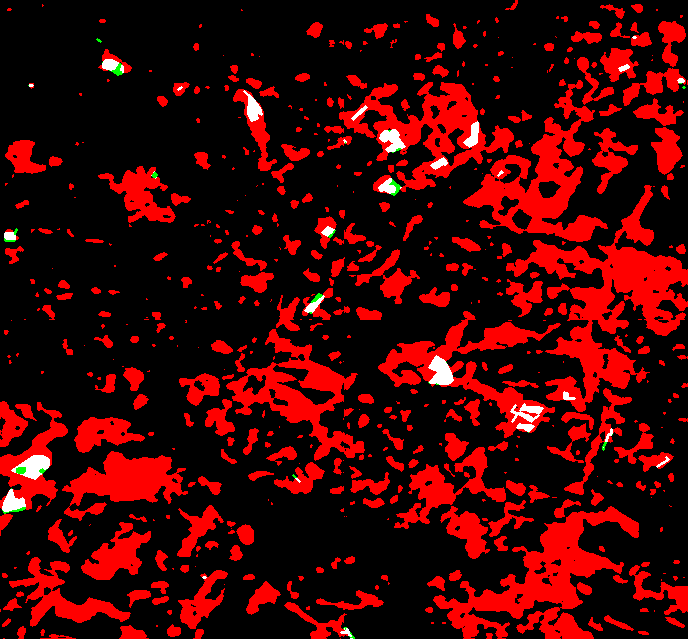

abudhabi


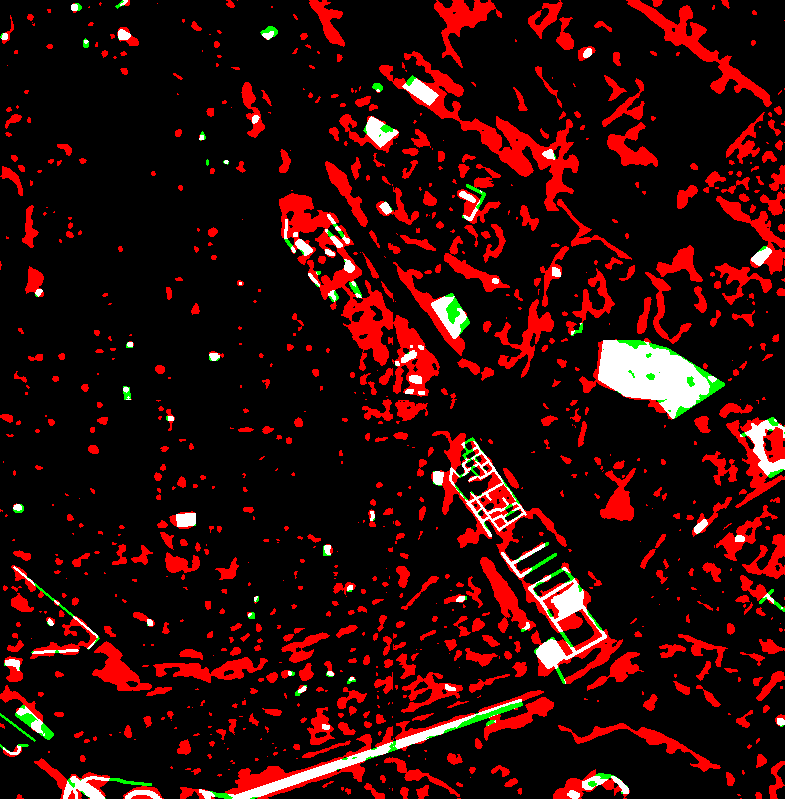

cupertino


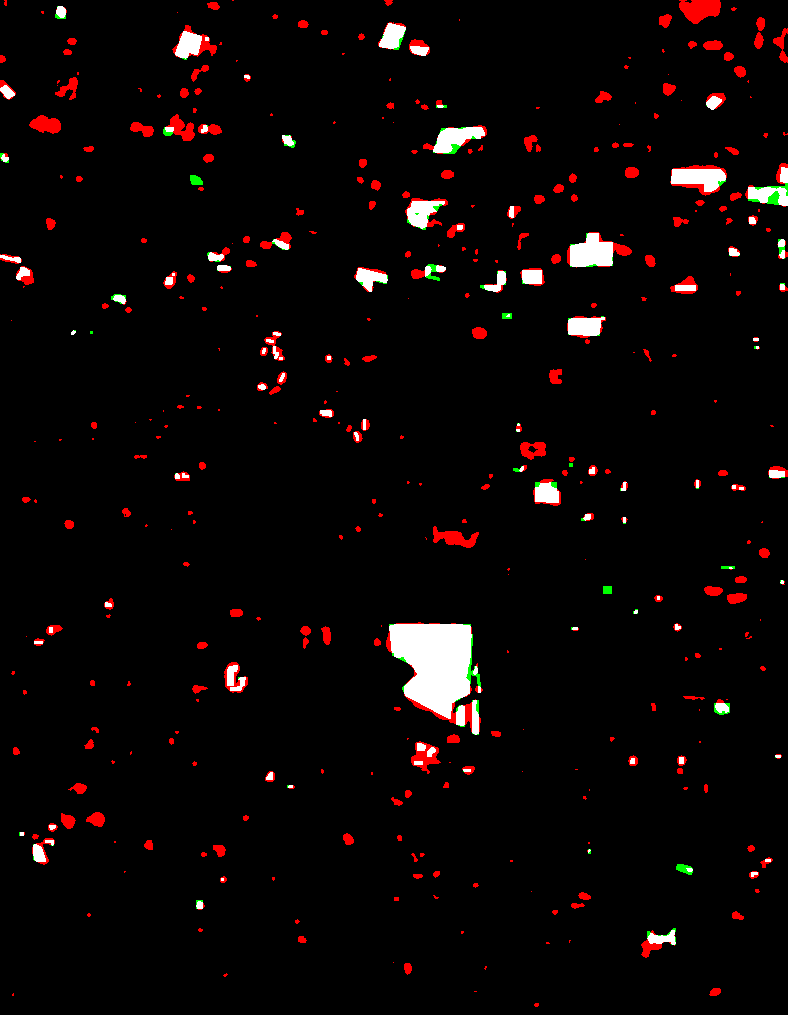

pisa


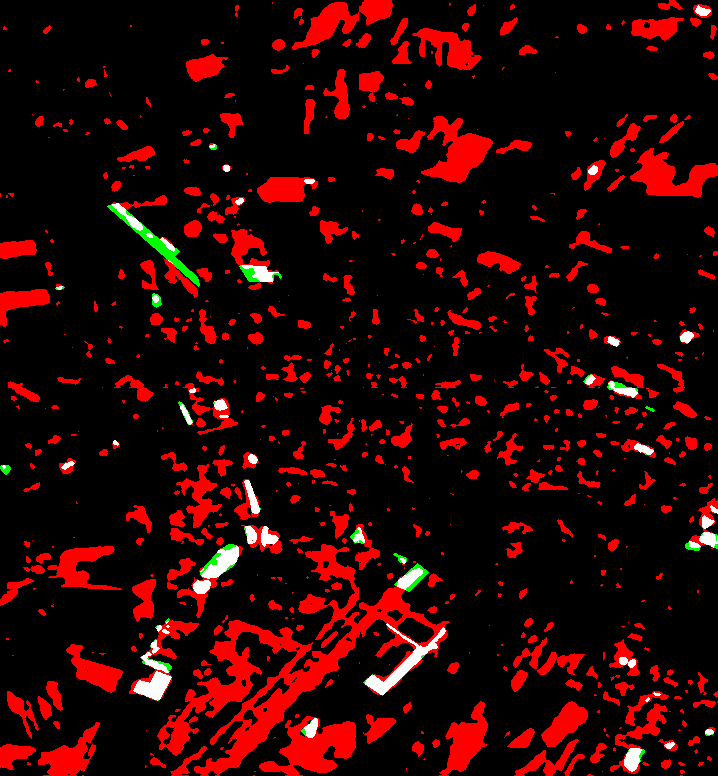

beihai


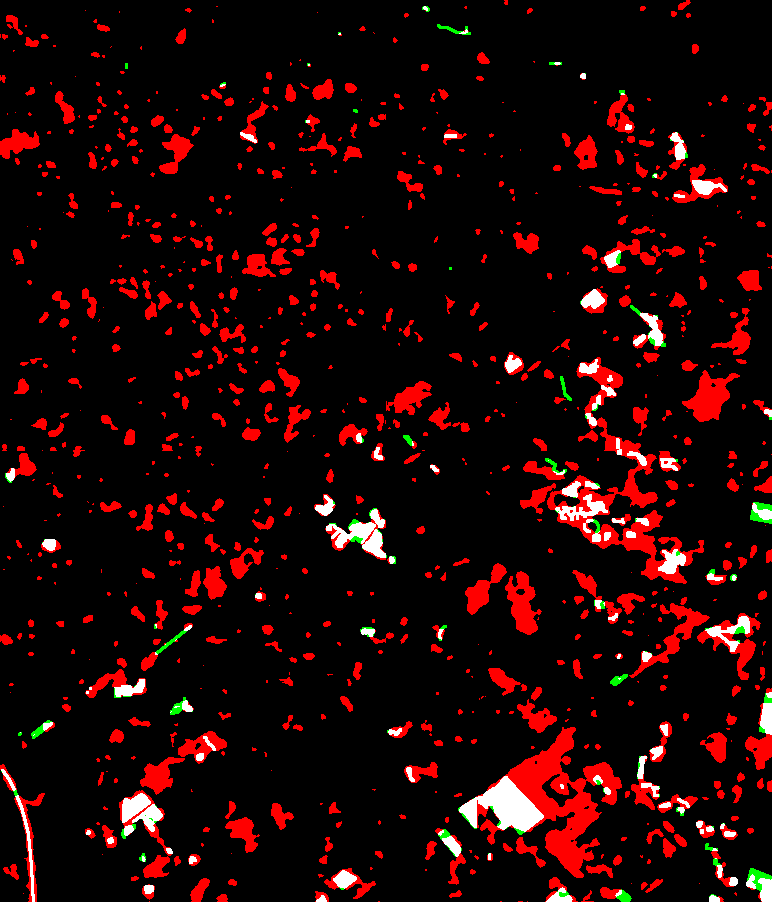

hongkong


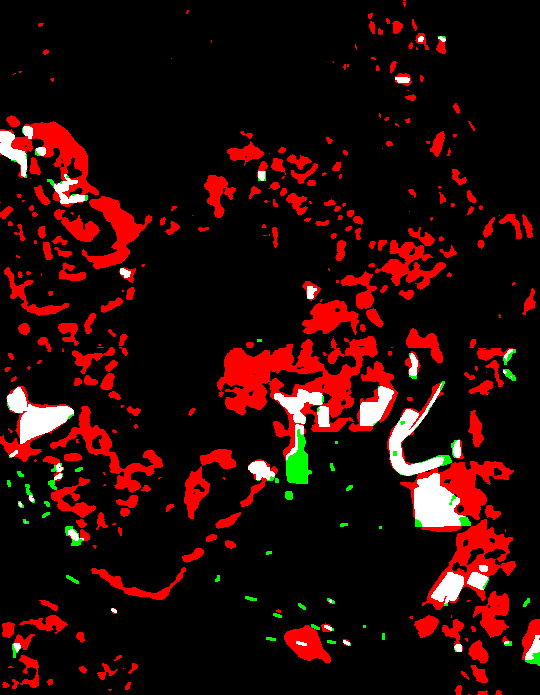

beirut


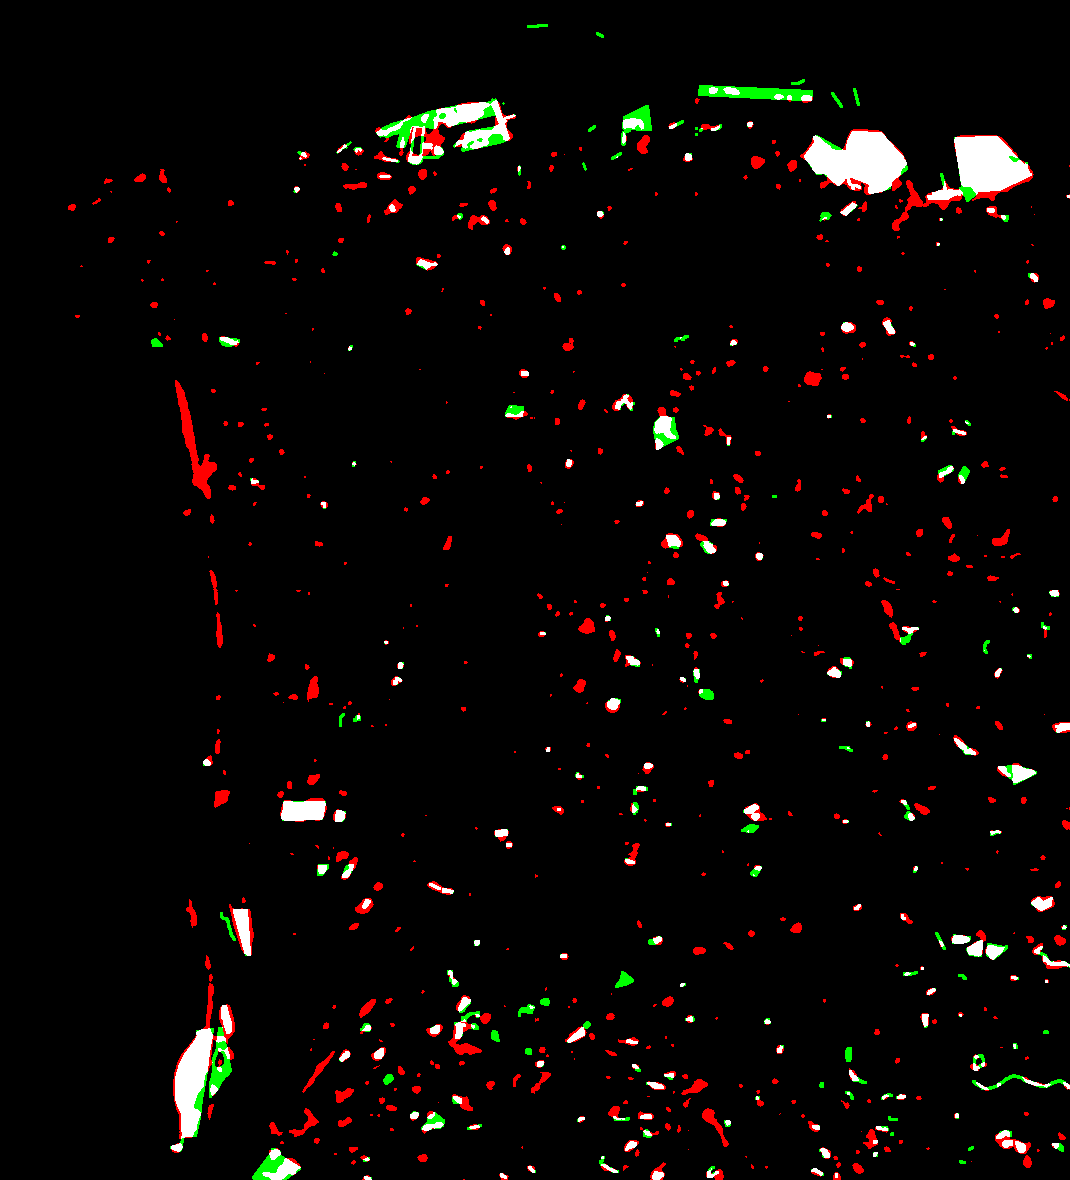

mumbai


KeyboardInterrupt: ignored

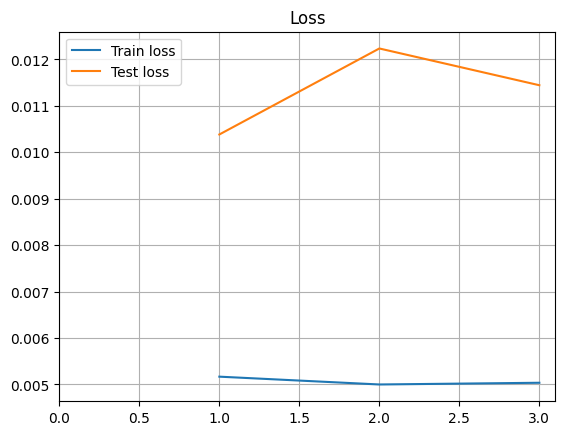

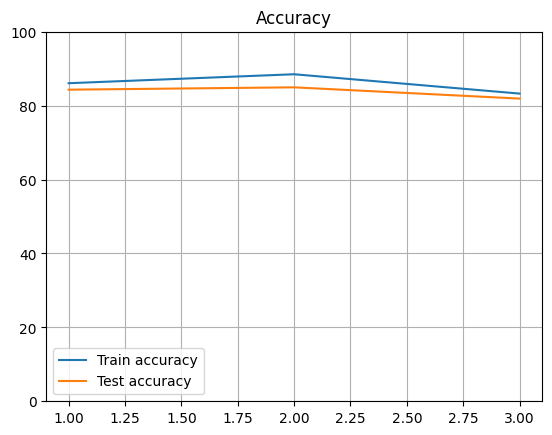

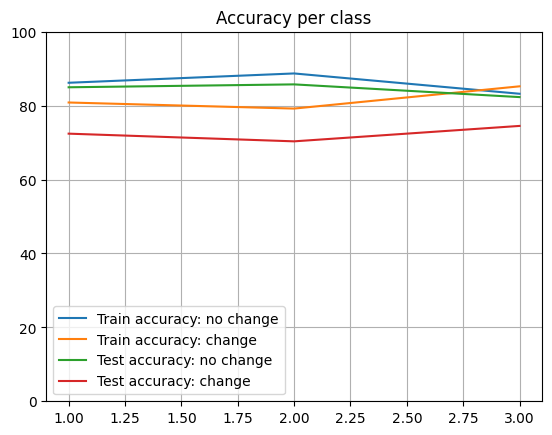

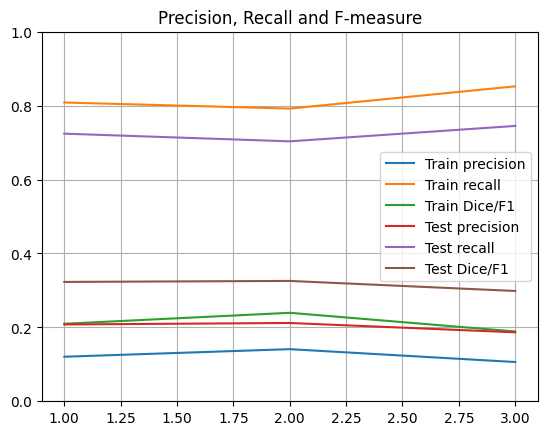

In [ ]:
def train(n_epochs = 30, save = True):
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    #testing: lr=0.001 e lr=0.0001
    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
        
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    
    
    for epoch_index in range(N_EPOCHS):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float()).to(device)
            I2 = Variable(batch['I2'].float()).to(device)
            label = Variable(batch['label']).to(device)

            optimizer.zero_grad()
            output = net(I1, I2)
            
            if USE_SIGMOID: loss = criterion(output, label.unsqueeze(1))
            else: loss = criterion(output, label.long())
            #print(output.shape)
            #print(loss.item(),loss.mean(),loss.sum())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_set_imgs)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_set_imgs)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.display(plt.gcf())
        
        
#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out


def test(dset):

    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    N = 2
    
    class_correct = list(0. for i in range(N))
    class_total = list(0. for i in range(N))
    class_accuracy = list(0. for i in range(N))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    if dset.train:
      req_set=train_set
    else:
      req_set=test_set

    for img_index in req_set:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape

        # Crea un'immagine RGB bianca delle stesse dimensioni dell'immagine di input
        result_image = np.zeros((s[0], s[1], 3), dtype=np.uint8) 

       
        print(img_index)

        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        N1=N
        N2=N

        #if USE_TORCH_NET:
        #    N=16
        #    steps0 = np.arange(0,s[0],N)
        #    steps1 = np.arange(0,s[1],N)
        #    N1=ceil(s[0]/N)-1
        #    N2=ceil(s[1]/N)-1
        
        for ii in range(N1):
            for jj in range(N2):
                #if USE_TORCH_NET:
                #    xmin = steps0[ii]
                #   
                #    xmax = steps0[ii+1]
                #    ymin = steps1[jj]
            #
                #    ymax = steps1[jj+1]                    
                #    
                #else: 
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = steps1[jj]
                if jj == N-1:
                    ymax = s[1]
                else:
                        ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                #print(cm_full.shape)

                I1=torch.from_numpy(I1)
                I2=torch.from_numpy(I2)

                I1 = Variable(torch.unsqueeze(I1, 0).float()).to(device)
                I2 = Variable(torch.unsqueeze(I2, 0).float()).to(device)
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).to(device)


                output = net(I1, I2)
                if USE_SIGMOID: 
                  loss = criterion(output, cm.unsqueeze(1))
                  output=F.sigmoid(output)
                  #print(output)
                  predicted = torch.round(output).squeeze(1)
                  #print(predicted)

                else: 
                  loss = criterion(output, cm.long())
                  output=F.log_softmax(output,dim=1)
                  _, predicted = torch.max(output.data, 1)
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
   
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                #print(pr.shape)
                #print(cm.shape)
                #print(xmin,xmax,ymin,ymax)
                # Colora l'immagine risultato in base alla predizione

                pr=pr[0]
                gt=gt[0]

                pr_and_gt=np.logical_and(pr, gt)
                not_pr_and_not_gt=np.logical_and(np.logical_not(pr), np.logical_not(gt))
                pr_and_not_gt=np.logical_and(pr, np.logical_not(gt))
                not_pr_and_gt=np.logical_and(np.logical_not(pr), gt)
                
                tp += pr_and_gt.sum()
                tn += not_pr_and_not_gt.sum()
                fp +=pr_and_not_gt.sum()
                fn += not_pr_and_gt.sum()
                
              
                result_image[xmin:xmax,ymin:ymax][pr_and_gt] = [255, 255, 255]
                result_image[xmin:xmax,ymin:ymax][not_pr_and_not_gt] = [0, 0, 0]
                result_image[xmin:xmax,ymin:ymax][pr_and_not_gt] = [255, 0, 0]
                result_image[xmin:xmax,ymin:ymax][not_pr_and_gt] = [0, 255, 0]
                
        # Mostra l'immagine risultato
        result_image = Image.fromarray(result_image)
        result_image.show()
        result_image.save(img_index+'.png')

    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(N):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec
    
    
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)
    


In [ ]:
from google.colab import files

for loc in all_locs:
  files.download(loc+'.png')
  
if (USE_SIAMESE):
  files.download('FC-SIAM-DIFF-01-loss.png')
  files.download('FC-SIAM-DIFF-02-accuracy.png')
  files.download('FC-SIAM-DIFF-03-accuracy-per-class.png')
  files.download('FC-SIAM-DIFF-04-prec-rec-fmeas.png')
else:
  files.download('FC-EF-01-loss.png')
  files.download('FC-EF-02-accuracy.png')
  files.download('FC-EF-03-accuracy-per-class.png')
  files.download('FC-EF-04-prec-rec-fmeas.png')